# House Prices - Advanced Regression Techniques

## Data Preparation

In [1]:
import pandas as pd

df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Separate the features and the label.

In [3]:
y = df['SalePrice']
X = df.drop('SalePrice', axis=1)

## Data Wrangling

We will remove *Id* column and those with too many null values.

In [4]:
X.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

Other columns will be replaced with their respective mean value.

In [5]:
X.fillna(X.mean(), inplace=True)

Outliers can have an adverse effect when training regression models. Let's check if there is any.

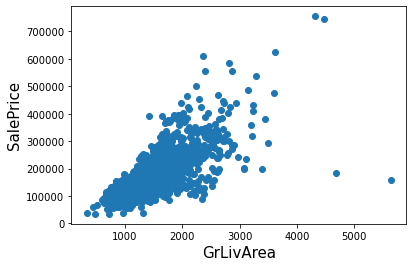

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X['GrLivArea'], y=y)
plt.xlabel('GrLivArea', fontsize=15)
plt.ylabel('SalePrice', fontsize=15)
plt.show()

*GrLivArea* feature has a strong positive correlation with our target feature, *SalesPrice*. However, two points are far from the general distribution. Remove those.

In [7]:
cond1 = X['GrLivArea'] > 4000
cond2 = y < 500000
outlier_indices = X[cond1 & cond2].index
X.drop(outlier_indices, axis=0, inplace=True)
y.drop(outlier_indices, axis=0, inplace=True)

Later we will train linear models. They are sensitive to the skewedness of the dataset. Let's find out which numeric columns are skewed and log-scale those.

In [8]:
from scipy.stats import skew

numeric_feature_indices = X.dtypes[X.dtypes != 'object'].index
skewed_numeric_features = X[numeric_feature_indices].apply(skew)
skewed_numeric_features = skewed_numeric_features[skewed_numeric_features > 1]
print(skewed_numeric_features.sort_values(ascending=False))

MiscVal          24.434913
PoolArea         15.932532
LotArea          12.560986
3SsnPorch        10.286510
LowQualFinSF      8.995688
KitchenAbvGr      4.480268
BsmtFinSF2        4.247550
ScreenPorch       4.114690
BsmtHalfBath      4.095895
EnclosedPorch     3.083987
MasVnrArea        2.692313
OpenPorchSF       2.337421
LotFrontage       1.692976
WoodDeckSF        1.544214
MSSubClass        1.405563
GrLivArea         1.009951
dtype: float64


In [9]:
import numpy as np

X[skewed_numeric_features.index] = X[skewed_numeric_features.index].apply(np.log1p)

Columns of string type cannot be filled with the mean value. We will one-hot encode those and the null values will automatically be handled.

In [10]:
X = pd.get_dummies(X)

Split the dataset into train and test parts.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Train Model

We are going to use a stacking ensemble with several linear models and tree-based models.

In [12]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

ridge = Ridge(alpha=8)
lasso = Lasso(alpha=0.001)
xgb_regressor = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_regressor = LGBMRegressor(
    n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10)
estimators = [
    ('ridge', ridge),
    ('lasso', lasso),
    ('xgb_regressor', xgb_regressor),
    ('lgbm_regressor', lgbm_regressor)
]
final_estimator = Lasso(alpha=0.0005)
stacking_regressor = StackingRegressor(estimators, final_estimator, cv=5)

stacking_regressor.fit(X_train, y_train)

/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188974245750.5427, tolerance: 681603009.1521446
  model = cd_fast.enet_coordinate_descent(
/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140935467794.34488, tolerance: 531583418.9053459
  model = cd_fast.enet_coordinate_descent(
/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134329248831.70123, tolerance: 554726948.0562598
  model = cd_fast.enet_coordinate_descent(
/usr/local/Caskroom/min

StackingRegressor(cv=5,
                  estimators=[('ridge', Ridge(alpha=8)),
                              ('lasso', Lasso(alpha=0.001)),
                              ('xgb_regressor',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.05,
                                            max_delta_step=None, max_depth=None,
                                            min_chi...
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                       

## Test Model

In [13]:
from sklearn.metrics import mean_squared_log_error

predictions = stacking_regressor.predict(X_test)
msle = mean_squared_log_error(y_test, predictions)
rmsle = msle**0.5
print(f'Root mean squared log error: {rmsle:.3f}')

Root mean squared log error: 0.113
